In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

hidden_size = 512


/Users/panda/anaconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, bottleneck_dim=64):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_blocks):
            shortcut_layers = []
            shortcut_layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())  # Using ReLU for simplicity; you can choose other activations as needed
            shortcut_layers.append(nn.Linear(bottleneck_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.Linear(bottleneck_dim, hidden_dim))
            # shortcut_layers.append(nn.BatchNorm1d(num_features=hidden_dim))
            shortcut_layers.append(nn.Dropout())
            self.layers.append(nn.Sequential(*shortcut_layers))

        self.output_layer= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.layers:
            residual = layer(x)
            x = x + residual # shortcut
        return self.output_layer(x)


def pairwise_cosine_similarity(Q, K):
    """
    Q: (N, d)
    K: (N, L, d)
    """
    attention_scores = torch.matmul(Q.unsqueeze(1), K.transpose(-2, -1)).squeeze(1) # [N, L]
    # denominator = torch.sqrt((Q**2).sum(-1).unsqueeze(-1) * (K**2).sum(-1).unsqueeze(-2))
    denominator = (K**2).sum(-1) # [N, L]
    attention_weights = attention_scores / (denominator + 1e-5)
    return attention_weights # [N, L]


def normalize(x, device):
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).reshape(1,-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).reshape(1,-1,1,1)
    return (x - mean) / std


def convert_mask_patch(pixel_values, mask, h_patch, w_patch):
    reshaped_mask = mask.reshape(-1, h_patch, w_patch).unsqueeze(1) # [N, 1, h_patch ,w_patch]
    image_size = pixel_values.shape[-2:]
    reshaped_mask = torch.nn.functional.interpolate(reshaped_mask, size=image_size, mode='nearest')
    return pixel_values * reshaped_mask + (1 - reshaped_mask) * pixel_values.mean(dim=(-1,-2), keepdim=True)


def idx_to_selector(idx_tensor, selection_size):
    """
    Convert a labels indices tensor of shape [batch_size] 
    to one-hot encoded tensor [batch_size, selection_size]

    """
    batch_size = idx_tensor.shape[0]
    dummy = torch.arange(selection_size, device=idx_tensor.device).unsqueeze(0).expand(batch_size, -1)
    extended_idx_tensor = idx_tensor.unsqueeze(-1).expand(-1, selection_size)
    return (dummy == extended_idx_tensor).float()


class SurrogateInterpretation(nn.Module):
    def __init__(self, query_vector_size) -> None:
        """
        pred_model: prediction model
        classifier_head: last fully connected layer 
        """
        super().__init__()

        # self.feature_extractor = feature_extractor
        patch_size = 16
        n_patches = (224 * 224) // (patch_size * patch_size)
        self.n_patches = n_patches

        self.h_patch = 224 // patch_size
        self.patch_embedding = nn.Conv2d(3, query_vector_size, kernel_size=patch_size, stride=patch_size)


        # Transform function to non-linearly transform feature map embedding to the representation space
        self.transform_func = MLP(input_dim=query_vector_size,
                                  hidden_dim=query_vector_size,
                                  output_dim=1,
                                  num_blocks=5,
                                  bottleneck_dim=64)
        # self.attention = SimplifiedAttention(embed_size=query_vector_size)
        # self.classifer = nn.Linear(query_vector_size, num_labels, bias=False)
        
        self.cls_loss_func = nn.CrossEntropyLoss(reduction='none')
        # self.sim_loss_func = nn.MSELoss()
        # # self.cls_loss_func = nn.NLLLoss()
        # self.kl_loss = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        # self.cossim_loss_func = nn.CosineSimilarity(dim=-1)
    
    
    def compute_loss(self, pred_gated, pred_nongated, pseudo_label, gate):    
        """
        pred: [N, 1000]
        pseudo_label: [N,]
        gate: [N, L]
        """
        # true_selector = idx_to_selector(pseudo_label, selection_size=pred_gated.shape[-1]) # [N, 1000]
        # prob = torch.softmax(pred_gated, dim=-1) # [N, 1000]
        # true_prob = (prob * true_selector).sum(-1) # [N,] probability
        pred_label = pred_gated.argmax(dim=-1).view(-1) # [N,]

        mask = (pred_label == pseudo_label).float() # [N,] mask
        batch_acc = mask.mean()

        nongated_mask = (pred_nongated.argmax(dim=-1).view(-1) == pseudo_label).float()
        batch_nongated_acc = nongated_mask.mean()

        cls_loss = self.cls_loss_func(pred_gated, pseudo_label)
        cls_loss = ((1 - mask) * cls_loss).mean()
        # cls_nongated_loss = - self.cls_loss_func(pred_nongated, pseudo_label)
        def compute_adv_loss(pred_nongated, pseudo_label, nongated_mask):
            true_selector = idx_to_selector(pseudo_label, selection_size=pred_nongated.shape[-1]) # [N, 1000]
            prob = torch.softmax(pred_nongated, dim=-1) # [N, 1000]
            prob = (prob * true_selector).sum(-1) #[N,]
            adv_loss = - torch.log(1 - prob + 1e-5) * nongated_mask 
            adv_loss = adv_loss.mean()
            return adv_loss
        cls_nongated_loss = compute_adv_loss(pred_nongated, pseudo_label, nongated_mask)
        # (1 - mask) is the ones with incorrect prediction
        # if the the prediction is correct, then mask the input furhter by gate
        masked_gate = gate * mask.unsqueeze(-1) # (N, L)
        gate_loss = masked_gate.sum() / (mask.sum())
        # gate_loss = gate.sum(-1).mean()
        var_loss = - gate.var(dim=-1).mean()

        loss = 1 * cls_loss + cls_nongated_loss #+ 0.005 * gate_loss # + 1 * var_loss
        # print(cls_nongated_loss)

        return {'loss':loss, 
                'cls_loss': cls_loss,
                'gate_loss': gate_loss,
                'batch_acc': batch_acc,
                "cls_nongated_loss": cls_nongated_loss,
                "batch_nongated_acc": batch_nongated_acc,
                "var_loss": var_loss,
                }
        
    
    def forward(self, pixel_values, query_vector):
        """ 
        pixel_values: [N, 3, 224, 224]
        query_vector: [N, d]
        pseudo_probs: [N, 1000]
        label: [N,]
        """     
        h_patch = self.h_patch

        self_query = self.patch_embedding(pixel_values).flatten(-2) #[N, d, L]
        # print(self_query.shape)
        self_query = self_query.permute(0, 2, 1) # [N, L, d]
        gate_repr = self.transform_func(self_query).squeeze(-1) # [N, L, d] ->  [N, L, 1] convert to L patch prediction
        gate_logits = torch.sigmoid(gate_repr)

        # gate = torch.sigmoid(gate_logits) # [N, L] convert to values between [0, 1]
        gate = torch.clamp(torch.softmax(gate_logits, dim=-1) * 100, 0, 1)
        # print("gate shape: ", gate.shape)
        # print("gate", gate[0, :10].flatten())
        # gate = torch.clamp(torch.softmax(gate_logits, dim=-1) * 80, 0, 1)
        gated_pixel_values = convert_mask_patch(pixel_values=pixel_values, mask=gate, h_patch=h_patch, w_patch=h_patch) # N, 

        nongated_pixel_values = convert_mask_patch(pixel_values=pixel_values, mask=(1-gate), h_patch=h_patch, w_patch=h_patch) # N,


        return {"gated_pixel_values" :gated_pixel_values,
                "nongated_pixel_values": nongated_pixel_values,
                "query_vector": query_vector,
                "gate": gate,
        }


In [3]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_mean, image_std = mean, std
size = 224

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

from datasets import load_dataset
dataset = load_dataset("mrm8488/ImageNet1K-val")
dataset = dataset['train']
splits = dataset.train_test_split(test_size=0.1, seed=2)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
from torchvision.models import resnet18, ResNet152_Weights, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor

pred_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
out_layers = {
    "avgpool": 'features',
    "fc": 'logits'
}
pred_model = create_feature_extractor(pred_model, out_layers)
pred_model.to(device)
pred_model.eval()
pred_model.eval()

model = SurrogateInterpretation(query_vector_size=hidden_size,) 
model.to(device)
model.load_state_dict(torch.load("model/resnet18_softmax_gate2.pt"))

<All keys matched successfully>

In [5]:
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=1, shuffle=False)

def get_pseudo_logits(pred_model, inputs):
    # obtain the cls token output of the last hidden state
    with torch.no_grad():
        outputs = pred_model(inputs)
        query_vector = outputs['features'] # (N, d)
        query_vector = query_vector.reshape(query_vector.shape[0], -1)
        pseudo_logits = outputs['logits']
    return pseudo_logits, query_vector

model.eval()
with torch.no_grad():
    for idx, data in enumerate(val_dataloader):
        pixel_values = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)
        pseudo_label = pseudo_logits.argmax(-1)

        outputs = model(pixel_values=pixel_values, 
                        query_vector=query_vector)
        gated_pixel_values = outputs['gated_pixel_values']
        nongated_pixel_values = outputs['nongated_pixel_values']
        gate = outputs['gate']
        pred_gated = pred_model(gated_pixel_values)['logits']
        pred_nongated = pred_model(nongated_pixel_values)['logits']

        loss_dict = model.compute_loss(pred_gated=pred_gated, pred_nongated=pred_nongated, pseudo_label=pseudo_label, gate=gate)
        loss = loss_dict['loss']
    
        print(f"loss: {loss.item():.4f}, cls_loss: {loss_dict['cls_loss'].item():.4f}, gate_loss: {loss_dict['gate_loss'].item():.4f}"
            f" batch_acc: {loss_dict['batch_acc'].item():.4f}, batch_nongated_acc: {loss_dict['batch_nongated_acc'].item():.4f}"
            f" var_loss {loss_dict['var_loss'].item():.4f}")
        break

loss: 1.0346, cls_loss: 0.0000, gate_loss: 100.0000 batch_acc: 1.0000, batch_nongated_acc: 1.0000 var_loss -0.0005


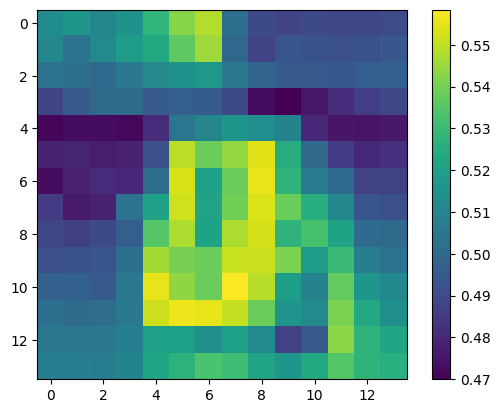

In [6]:
import matplotlib.pyplot as plt
idx = 0
plt.imshow(gate[idx].reshape(14,14).detach().cpu().numpy())
# Add a color bar
plt.colorbar()

True class:  cassette
Predicted class: pencil sharpener


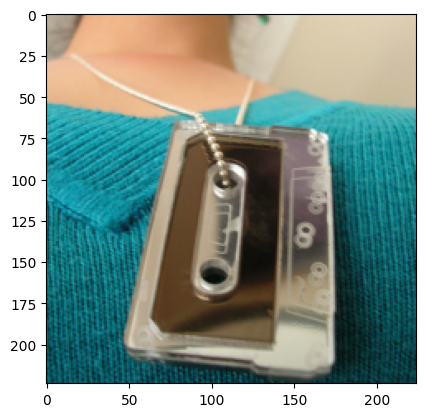

In [7]:
import numpy as np
from transformers import ViTConfig

pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)

ploted_image = pixel_values.detach().cpu().numpy() * np.array(std).reshape(1,-1,1,1) + np.array(mean).reshape(1,-1,1,1)
plt.imshow(ploted_image[idx].transpose(1, 2, 0))
# label = pseudo_label.item()
print("True class: ", config.id2label[label[idx].item()])
print("Predicted class:", config.id2label[pseudo_label[idx].item()])

In [41]:
def idx_to_selector(idx_tensor, selection_size):
    """
    Convert a labels indices tensor of shape [batch_size] 
    to one-hot encoded tensor [batch_size, selection_size]

    """
    batch_size = idx_tensor.shape[0]
    dummy = torch.arange(selection_size, device=idx_tensor.device).unsqueeze(0).expand(batch_size, -1)
    extended_idx_tensor = idx_tensor.unsqueeze(-1).expand(-1, selection_size)
    return (dummy == extended_idx_tensor).float()

def convert_mask_patch(pixel_values, mask, h_patch, w_patch):
    reshaped_mask = mask.reshape(-1, h_patch, w_patch).unsqueeze(1) # [N, 1, h_patch ,w_patch]
    image_size = pixel_values.shape[-2:]
    reshaped_mask = torch.nn.functional.interpolate(reshaped_mask, size=image_size, mode='nearest')
    return pixel_values * reshaped_mask + (1 - reshaped_mask) * pixel_values.mean(dim=(-1,-2), keepdim=True)


def obtain_masks_on_topk(attribution, topk):
    """ 
    attribution: [N, H_a, W_a]
    """
    H_a, W_a = attribution.shape[-2:]
    attribution_size = H_a * W_a
    attribution = attribution.reshape(-1, H_a * W_a) # [N, H_a*W_a]
    attribution_perturb = attribution + 1e-4*torch.randn_like(attribution) # to avoid equal attributions (typically all zeros or all ones)

    idx = int(topk * attribution_size / 100)
    a, _ = torch.topk(attribution_perturb, k=idx, dim=-1) 
    a = a[:, -1].unsqueeze(-1) # [N, 1]

    mask = (attribution_perturb >= a).float() #[N, H_a*W_a]
    return mask.reshape(-1, H_a, W_a) # [N, H_a, W_a]


def obtain_masked_input_on_topk(x, attribution, topk, mode='ins'):
    """ 
    x: [N, C, H, W]
    attribution: [N, H_a, W_a]
    """
    mask = obtain_masks_on_topk(attribution, topk) # [N, H_a, W_a]
    mask = mask.unsqueeze(1) # [N, 1, H_a, W_a]
    mask = F.interpolate(mask, size=x.shape[-2:], mode='nearest') # # [N, 1, H, W]
    if mode == 'ins':
        pass 
    elif mode == 'del':
        mask = 1. - mask
    else:
        raise ValueError('Enter game mode either as ins or del.')
    return x * mask # [N, C, H, W]


def obtain_masks_sequence(attribution):
    """ 
    attribution: [1, H_a, W_a]
    """
    H_a, W_a = attribution.shape[-2:]
    attribution_size = H_a * W_a
    attribution = attribution.reshape(-1, H_a * W_a) # [1, H_a*W_a]
    attribution = attribution + 1e-4 * torch.randn_like(attribution)
    a, _ = torch.sort(attribution, dim=-1, descending=True)
    idx = torch.ceil(torch.arange(100) * attribution_size / 100).int()
    a = a.reshape(-1, 1)
    a = a[idx,:] # [100, 1]
    res = (attribution > a).float() # [100, H_a*W_a]
    return res.reshape(-1, H_a, W_a)
    

def obtain_masked_inputs_sequence(x, attribution, mode='ins'):
    """ 
    x: [1, C, H, W]
    attribution: [1, H_a, W_a]
    """
    masks_sequence = obtain_masks_sequence(attribution) # [100, H_a, W_a]
    masks_sequence = masks_sequence.unsqueeze(1) # [100, 1, H_a, W_a]
    masks_sequence = F.interpolate(masks_sequence, size=x.shape[-2:], mode='nearest') # [100, 1, H, W]
    if mode == 'del':
        masks_sequence = 1.0 - masks_sequence
    elif mode == 'ins':
        pass
    else:
        raise ValueError('Enter game mode either as ins or del.')
    return x * masks_sequence # [100, C, H, W]


class EvalGame():
    """ Evaluation games
    """
    def __init__(self, model, output_dim=1000):
        """ 
        model: a prediction model takes an input and outputs logits
        """
        self.model = model
        self.output_dim = output_dim
    
    def get_insertion_score(self, x, attribution):
        return self.get_auc(x, attribution, 'ins')
    
    def get_deletion_score(self, x, attribution):
        return self.get_auc(x, attribution, 'del')
    
    def play_game(self, x, attribution, mode='ins'):
        """ 
        masking the input with a series of masks based on the attribution importance.
        x: [1, C, H, W] the batch dim must be 1
        attribution: [1, H_a, W_a] the batch dim must be 1

        """
        pseudo_label = self.model(x).argmax(-1) # [1, 1]
        selector = idx_to_selector(pseudo_label, self.output_dim) # [1, 1000]
        
        x_sequence = obtain_masked_inputs_sequence(x, attribution, mode=mode) # [100, C, H, W]
        probs = torch.softmax(self.model(x_sequence), dim=-1) # [100, 1000]
        probs = (probs * selector).sum(-1) # [100,]
        
        return probs
    
    def get_auc(self, x, attribution, mode='ins'):
        probs = self.play_game(x, attribution, mode)
        return probs.mean()
    
    def play_game_at_k(self, x, attribution, topk=50, mode='ins'):
        """ 
        x : [N, C, H, W]
        attribution: [N, H_a, W_a]
        """
        pseudo_label = self.model(x).argmax(-1) # [N, 1]
        selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]

        masked_x = obtain_masked_input_on_topk(x, attribution, topk, mode) # [N, C, H, W]
        probs = torch.softmax(self.model(masked_x), dim=-1) #[N, 1000]
        probs = (probs * selector).sum(-1) # [N,]
        return probs
        




In [76]:
from tqdm import tqdm
import time 
import numpy as np

pred_model.eval()
eval_game = EvalGame(model=lambda x: pred_model(x)['logits'], output_dim=1000)

test_batch_size = 256
test_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=test_batch_size, shuffle=False)


ins_score_list = []
del_score_list = []
with torch.no_grad():
    print("evaluation started: ")
    start_time = time.time()
    for idx, data in tqdm(enumerate(test_dataloader)):
        pixel_values = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        # pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)
        # pseudo_label = pseudo_logits.argmax(-1)

        # outputs = model(pixel_values=pixel_values, 
        #                 query_vector=query_vector)
        # gated_pixel_values = outputs['gated_pixel_values']
        # nongated_pixel_values = outputs['nongated_pixel_values']
        # gate = outputs['gate']

        gate = torch.rand(label.shape[0], 14, 14).to(device)

        # obtain ins and del scores and add to lists
        x = pixel_values 
        attribution = gate.reshape(-1,14,14)

        ins_score_list.append(eval_game.play_game_at_k(x, attribution, 50, 'ins').cpu().numpy())
        del_score_list.append(eval_game.play_game_at_k(x, attribution,50, 'del').cpu().numpy())
        
        # Output stats
        if (idx) % 1 == 0:
            proc_time = (time.time() - start_time)
            ins_score = np.concatenate(ins_score_list, axis=0).mean()
            del_score = np.concatenate(del_score_list, axis=0).mean()
            tqdm.write(f"Time cost per batch: {proc_time:.4f} seconds")
            tqdm.write(f"Average so far: ins_score {ins_score:.4f}, del_score{del_score:.4f}")
            start_time = time.time()
            


evaluation started: 


1it [00:37, 37.27s/it]

Time cost per batch: 37.2657 seconds
Average so far: ins_score 0.0290, del_score0.0334


2it [00:48, 22.21s/it]

Time cost per batch: 11.6594 seconds
Average so far: ins_score 0.0306, del_score0.0296


3it [00:53, 13.99s/it]

Time cost per batch: 4.1968 seconds
Average so far: ins_score 0.0305, del_score0.0248


4it [01:04, 13.10s/it]

Time cost per batch: 11.7240 seconds
Average so far: ins_score 0.0282, del_score0.0252


5it [01:09, 10.07s/it]

Time cost per batch: 4.7056 seconds
Average so far: ins_score 0.0272, del_score0.0248


6it [01:25, 12.01s/it]

Time cost per batch: 15.7826 seconds
Average so far: ins_score 0.0261, del_score0.0246


7it [01:35, 11.50s/it]

Time cost per batch: 10.4468 seconds
Average so far: ins_score 0.0243, del_score0.0240


8it [01:43, 10.38s/it]

Time cost per batch: 7.9677 seconds
Average so far: ins_score 0.0235, del_score0.0231


9it [01:47,  8.44s/it]

Time cost per batch: 4.1813 seconds
Average so far: ins_score 0.0220, del_score0.0222


10it [01:55,  8.12s/it]

Time cost per batch: 7.3786 seconds
Average so far: ins_score 0.0219, del_score0.0228


11it [01:58,  6.59s/it]

Time cost per batch: 3.1180 seconds
Average so far: ins_score 0.0217, del_score0.0233


12it [02:02,  5.70s/it]

Time cost per batch: 3.6677 seconds
Average so far: ins_score 0.0227, del_score0.0245


13it [02:10,  6.40s/it]

Time cost per batch: 8.0232 seconds
Average so far: ins_score 0.0234, del_score0.0247


14it [02:25,  9.14s/it]

Time cost per batch: 15.4440 seconds
Average so far: ins_score 0.0240, del_score0.0250


15it [02:30,  7.92s/it]

Time cost per batch: 5.0867 seconds
Average so far: ins_score 0.0237, del_score0.0248


16it [02:34,  6.66s/it]

Time cost per batch: 3.7250 seconds
Average so far: ins_score 0.0237, del_score0.0244


17it [02:39,  6.25s/it]

Time cost per batch: 5.3075 seconds
Average so far: ins_score 0.0235, del_score0.0237


18it [02:43,  5.38s/it]

Time cost per batch: 3.3409 seconds
Average so far: ins_score 0.0230, del_score0.0234


19it [02:46,  4.70s/it]

Time cost per batch: 3.1325 seconds
Average so far: ins_score 0.0237, del_score0.0245


20it [02:49,  8.46s/it]

Time cost per batch: 3.0215 seconds
Average so far: ins_score 0.0235, del_score0.0243


In [44]:
ins_score = np.concatenate(ins_score_list, axis=0).mean()
del_score = np.concatenate(del_score_list, axis=0).mean()
print(ins_score)
print(del_score)


0.2389627
0.13668117


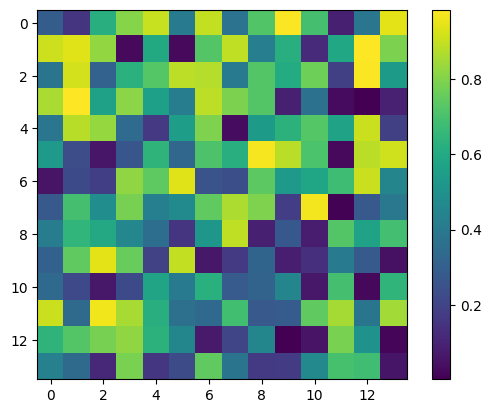

In [78]:
import matplotlib.pyplot as plt
idx = 0
plt.imshow(gate[idx].reshape(14,14).detach().cpu().numpy())
# Add a color bar
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class:  artichoke, globe artichoke
Predicted class: artichoke, globe artichoke


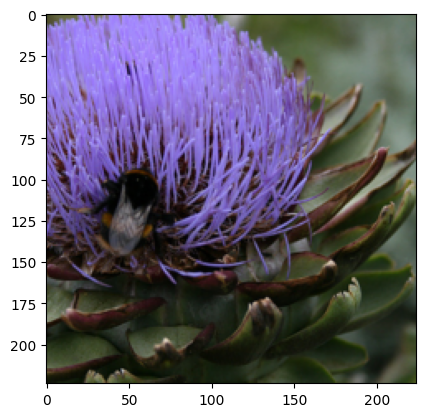

In [73]:
import numpy as np
from transformers import ViTConfig

pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)

ploted_image = pixel_values.detach().cpu().numpy() * np.array(std).reshape(1,-1,1,1) + np.array(mean).reshape(1,-1,1,1)
plt.imshow(ploted_image[idx].transpose(1, 2, 0))
# label = pseudo_label.item()
print("True class: ", config.id2label[label[idx].item()])
print("Predicted class:", config.id2label[pseudo_label[idx].item()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


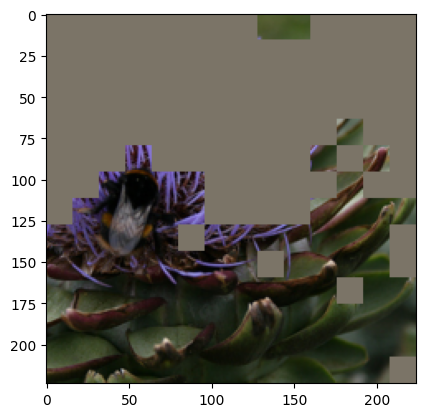

In [74]:
masked_image = obtain_masked_input_on_topk(x[idx].unsqueeze(0), attribution[idx].unsqueeze(0), 50, mode='ins')
ploted_image = masked_image.detach().cpu().numpy() * np.array(std).reshape(1,-1,1,1) + np.array(mean).reshape(1,-1,1,1)
plt.imshow(ploted_image[0].transpose(1, 2, 0))

In [11]:
attribution = gate[idx].reshape(-1,14,14)
x = pixel_values[idx].unsqueeze(0)
b = obtain_masked_inputs_sequence(x, attribution)
b.shape

torch.Size([100, 3, 224, 224])

In [12]:
eval_game = EvalGame(model=lambda x: pred_model(x)['logits'], output_dim=1000)
print("insertion score: ", eval_game.get_insertion_score(x, attribution))
print("deletion score: ", eval_game.get_deletion_score(x, attribution))

insertion score:  tensor(0.0396, device='mps:0', grad_fn=<MeanBackward0>)
deletion score:  tensor(0.0165, device='mps:0', grad_fn=<MeanBackward0>)


In [13]:
eval_game.play_game(x, attribution,'del')

tensor([4.1326e-01, 4.3090e-01, 2.5164e-01, 1.9533e-01, 1.5900e-01, 7.3306e-02,
        3.6883e-02, 2.1582e-02, 2.1642e-02, 2.2065e-02, 1.4872e-02, 8.8676e-03,
        3.8068e-03, 2.2408e-03, 2.2607e-03, 1.8771e-03, 5.9830e-04, 4.2205e-04,
        1.7918e-04, 3.1201e-05, 2.5045e-05, 1.4583e-05, 3.7238e-05, 2.4497e-05,
        1.7404e-05, 1.8021e-05, 1.5023e-05, 1.0794e-05, 6.6198e-06, 9.1524e-06,
        9.4832e-06, 1.2576e-05, 5.0659e-06, 5.3782e-06, 5.5622e-06, 5.9363e-06,
        2.9659e-06, 2.6210e-06, 1.4946e-06, 1.9479e-06, 1.7952e-06, 1.6491e-06,
        3.3543e-06, 4.9144e-06, 1.9086e-06, 4.2991e-06, 7.8098e-06, 6.0218e-06,
        3.7638e-06, 7.2603e-06, 6.9847e-06, 1.0890e-05, 1.1882e-05, 1.2367e-05,
        1.8482e-05, 2.2992e-05, 1.3782e-05, 1.1436e-05, 1.4653e-05, 2.1907e-05,
        3.6625e-05, 1.8348e-05, 2.1078e-05, 3.2780e-05, 8.2810e-05, 1.6241e-04,
        2.3468e-04, 5.5382e-05, 1.3664e-04, 7.9792e-05, 2.7046e-05, 2.5838e-05,
        2.9185e-05, 1.9489e-05, 3.2243e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


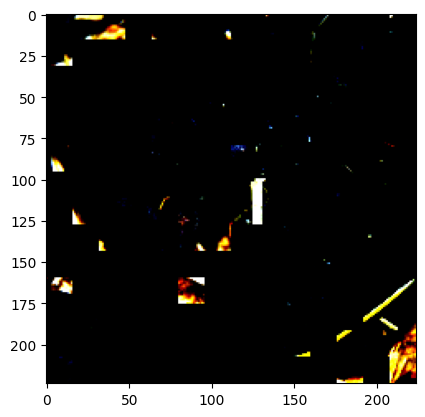

In [21]:
plt.imshow(b[50].cpu().numpy().transpose(1, 2, 0))

In [15]:
a.shape

NameError: name 'a' is not defined